In [1]:
import os
from glob import glob
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn import linear_model
from sklearn.metrics import RocCurveDisplay, auc, mean_squared_error, roc_curve
from sklearn.model_selection import RandomizedSearchCV
from sklearn.utils.fixes import loguniform
from scipy.interpolate import interp1d

from label_flip_revised.utils import create_dir

In [2]:
PATH_ROOT = Path(os.getcwd()).absolute().parent
print(PATH_ROOT)

/home/lukec/workspace/diva_01


In [3]:
path_output = os.path.join(PATH_ROOT, 'results_plot')
print(path_output)
create_dir(path_output)

/home/lukec/workspace/diva_01/results_plot


In [4]:
df_falfa = pd.read_csv(os.path.join(PATH_ROOT, 'results', 'real', 'real_falfa_nn_db.csv'))
print(df_falfa.shape)

(90, 38)


In [5]:
datanames = df_falfa['Data.Base'].unique()
print(datanames)

['breastcancer_std' 'texture_subset_std' 'ringnorm_subset_std'
 'australian_std' 'cmc_std' 'yeast_subset_std' 'abalone_subset_std'
 'phoneme_subset_std' 'banknote_std' 'htru2_subset_std']


In [6]:
print(df_falfa.columns)

Index(['Data', 'F1', 'F1 SD', 'F1v', 'F2', 'F3', 'F4', 'N1', 'N2', 'N2 SD',
       'N3', 'N3 SD', 'N4', 'N4 SD', 'T1', 'T1 SD', 'LSC', 'L1', 'L2', 'L3',
       'T2', 'T3', 'T4', 'C1', 'C2', 'Density', 'ClsCoef', 'Hubs', 'Hubs SD',
       'Path.Train', 'Path.Poison', 'Path.Test', 'Rate', 'Train.Clean',
       'Test.Clean', 'Train.Poison', 'Test.Poison', 'Data.Base'],
      dtype='object')


In [7]:
cols_cm = [
    'F1', 'F1 SD', 'F1v', 'F2', 'F3', 'F4', 'N1', 'N2', 'N2 SD',
    'N3', 'N3 SD', 'N4', 'N4 SD', 'T1', 'T1 SD', 'LSC', 'L1', 'L2', 'L3',
    'T2', 'T3', 'T4', 'C1', 'C2', 'Density', 'ClsCoef', 'Hubs', 'Hubs SD',
]
col_y = 'Test.Poison'

print(len(cols_cm))

28


In [8]:
attacks = ['falfa_nn', 'alfa_svm', 'rand_svm', 'poison_svm']

In [9]:
workspace_names = [f'diva_{i:02d}' for i in range(1,6)]
workspace_names

['diva_01', 'diva_02', 'diva_03', 'diva_04', 'diva_05']

In [10]:
def load_dataframes(workspace):
    dfs = []
    for att in attacks:
        df_ = pd.read_csv(os.path.join(PATH_ROOT.parent, workspace, 'results', 'real', f'real_{att}_db.csv'))
        df_['Attack'] = att
        dfs.append(df_)
    df = pd.concat(dfs, ignore_index=True)
    df['Prediction'] = 0.
    return df

In [11]:
df_dict = {}
for wname in workspace_names:
    df = load_dataframes(wname)
    df_dict[wname] = df

In [12]:
N_ITER_SEARCH = 100

In [13]:
alphas = {}

param = {'alpha': loguniform(1e-4, 10),}
for wname in workspace_names:
    X = df_dict[wname][cols_cm]
    y = df_dict[wname][col_y]
    regressor = linear_model.Ridge()
    param_search = RandomizedSearchCV(regressor, param_distributions=param, n_iter=N_ITER_SEARCH, n_jobs=-1)
    param_search.fit(X, y)

    best_estimator_ = param_search.best_estimator_.get_params()
    alphas[wname] = np.round(best_estimator_['alpha'], 4)

print(alphas)

{'diva_01': 0.0038, 'diva_02': 0.0364, 'diva_03': 0.0251, 'diva_04': 0.0106, 'diva_05': 0.0116}


In [14]:
IDX_PRED = df_dict[workspace_names[0]].columns.get_indexer(['Prediction'])
print(IDX_PRED)

[39]


In [15]:
for wname in workspace_names:
    df_ = df_dict[wname]
    alpha_ = alphas[wname]
    for dname in datanames:
        # Anything other than test set
        # Only train with 1 attack and 1 noise
        df_train_1 = df_[(df_['Data.Base'] != dname) & (df_['Attack'] == 'falfa_nn')]
        df_train_2 = df_[(df_['Data.Base'] != dname) & (df_['Attack'] == 'rand_svm')]
        df_train = pd.concat([df_train_1, df_train_2], ignore_index=True)
        X_train = df_train[cols_cm]
        y_train = df_train[col_y]

        regressor = linear_model.Ridge(alpha=alpha_)
        regressor.fit(X_train, y_train)

        for att in attacks:
            df_test = df_[(df_['Data.Base'] == dname) & (df_['Attack'] == att)]
            X_test = df_test[cols_cm]
            
            pred = regressor.predict(X_test)
            # Apply clipping
            pred = np.amin([pred, np.ones_like(pred)], axis=0)

            idx = df_[(df_['Data.Base'] == dname) & (df_['Attack'] == att)].index
            df_.iloc[idx, IDX_PRED] = pred

In [16]:
for att in attacks:
    RMSEs = []
    for wname in workspace_names:
        df_ = df_dict[wname]
        y_true = df_[df_['Attack'] == att]['Test.Poison']
        pred = df_[df_['Attack'] == att]['Prediction']
        rmse = np.sqrt(mean_squared_error(y_true, pred))
        RMSEs.append(rmse)
    rmse = np.mean(RMSEs)
    print(f'[{att}] {rmse:.3f}')

[falfa_nn] 0.126
[alfa_svm] 0.143
[rand_svm] 0.106
[poison_svm] 0.128


In [17]:
FONTSIZE = 14
FIGSIZE = (4, 4)
NAMES = {
    'falfa_nn': 'FALFA',
    'alfa_svm': 'ALFA',
    'poison_svm': 'PoisSVM',
}
COLORS = {
    'falfa_nn': '#d32f2f',
    'alfa_svm': '#1976d2',
    'poison_svm': '#388e3c',
}
THRESHOLD = 0.05

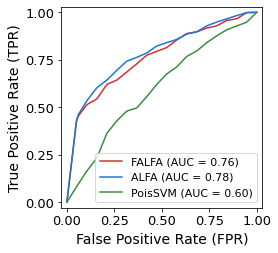

In [18]:
plt.rcParams["font.size"] = FONTSIZE
fig, ax = plt.subplots(figsize=FIGSIZE)
plt.gca().set_aspect('equal')  # Fix to square

mean_fpr = np.linspace(0, 1, 20, endpoint=True)
for att in ['falfa_nn', 'alfa_svm', 'poison_svm']:
    tprs = []
    for wname in workspace_names:
        df_ = df_dict[wname]
        y_true = (df_[df_['Attack'] == att]['Rate'].to_numpy() > THRESHOLD).astype(int)
        y_score = (df_[df_['Attack'] == att]['Train.Clean'] - df_[df_['Attack'] == att]['Prediction']).to_numpy()
        y_score = np.abs(y_score)
        fpr_, tpr_, thresholds = roc_curve(y_true, y_score)

        interp_tpr = np.interp(mean_fpr, fpr_, tpr_, left=0, right=1)
        interp_tpr[0] = 0
        tprs.append(interp_tpr)

    mean_tpr = np.mean(tprs, axis=0)
    mean_auc = auc(mean_fpr, mean_tpr)
    data_ = {
        'fpr': mean_fpr,
        'tpr': mean_tpr,
    }
    df_ = pd.DataFrame(data_)
    df_.to_csv(os.path.join(path_output, f'real_roc_mean_{att}.csv'), index=False)

    func = interp1d(mean_fpr, mean_tpr, kind='slinear')
    fpr_smooth = np.linspace(0, 1, 100, endpoint=True)
    tpr_smooth = func(fpr_smooth)

    roc_display = RocCurveDisplay(fpr=fpr_smooth, tpr=tpr_smooth, roc_auc=mean_auc).plot(ax=ax, name=NAMES[att], c=COLORS[att])

plt.legend(fontsize=FONTSIZE-3, loc='lower right')
plt.xticks(np.linspace(0, 1, num=5), fontsize=FONTSIZE-1)
plt.yticks(np.linspace(0, 1, num=5), fontsize=FONTSIZE-1)
plt.xlabel('False Positive Rate (FPR)', fontsize=FONTSIZE)
plt.ylabel('True Positive Rate (TPR)', fontsize=FONTSIZE)
plt.xlim(-0.03, 1.03)
plt.ylim(-0.03, 1.03)
plt.tight_layout()
path_output = os.path.join(path_output, 'roc_real_repeated.pdf')
plt.savefig(path_output, dpi=300)